# Model_Code
By Max Steele

In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

## Custom Functions for Analysis

In [2]:
def col_summary(df, col, dropna=False):
    
    """Takes in a Pandas DataFrame and specific column name. 
    Prints the number of unique values in the column and displays
    a DataFrame with the 5 most common and 5 least common values
    in that column as well as the count of each value. 
    Default is to also provide a count of NaN values.
    """
    
    pd.options.display.max_rows = 10
    
    print('***'*10)
    print(f"Summary of {col}")
    print('***'*10)
    print(f"Total unique values: {df[col].nunique()}")
    
    unique_vals = pd.DataFrame()
    unique_vals['count'] = pd.Series(df[col].value_counts(dropna=dropna))
    display(unique_vals)

In [3]:
def z_outliers(df, col, cutoff=3, verbose=True):
    
    """Takes in a DataFrame and column name to calculate the
    absolute value of the z-score for each observation. 
    Returns a Series with the same index as the data with True 
    if the observation is an outlier (defined as having a z-score 
    of 3 standard deviations [default] from the mean) or False if
    the observation is not an outlier.
    """
    
    z_scores = np.abs(stats.zscore(df[col]))
    z_scores = pd.Series(z_scores, index=df[col].index)
    idx_outliers = z_scores > cutoff
    
    if verbose:
        print('Z-score method found {} outliers.'.format(idx_outliers.sum()))
    
    return idx_outliers

In [4]:
def build_ols(df, target, predictor):
    
    """Takes in a DataFrame and column names of the target variable and predictor.
    Returns a Statsmodels OLS regression model.
    """
    
    formula = target + '~' + predictor
    model = ols(formula=formula, data=df).fit()
    
    return model

In [5]:
def check_ols_assumptions(model, df, target):
    
    """Takes in a Statsmodel OLS regression model, 
    the DataFrame from which that model was generated,
    and the target variable of that model as a string.
    Returns a Q-Q plot of the residuals and a plot of the residuals
    against the target variable to vizualize homoscedasticity of model errors.
    """
    
    fig, ax = plt.subplots(ncols=2,figsize=(14,5))
    ax1 = ax[0]
    ax2 = ax[1]

    sm.graphics.qqplot(model.resid, fit=True, line='45', ax=ax1, color='b')
    ax1.set_title('Q-Q Plot of Model Residuals', weight='bold', fontsize='x-large')
    ax1.set_xlabel(ax1.get_xlabel(), weight='bold')
    ax1.set_ylabel(ax1.get_ylabel(), weight='bold')

    sns.scatterplot(x=df[target], y=model.resid, ax=ax2, color='b')
    ax2.axhline(y=0, color='r')
    ax2.set_title('Homoscedasticity of Model Residuals', weight='bold', fontsize='x-large')
    ax2.set_xlabel(ax2.get_xlabel(), weight='bold')
    ax2.set_ylabel('Residual Value', weight='bold')
    
    return plt.show()

# Obtain Initial Datasets

In [6]:
## Read in data files
popn_df = pd.read_csv('share-of-population-urban.csv')
gdp_df = pd.read_csv('taxes-on-incomes-of-individuals-and-corporations-gdp.csv')

In [7]:
## Inspect first 5 rows of each df
display(popn_df.head())
gdp_df.head()

,Entity,Code,Year,Urban_Population
0,Afghanistan,AFG,1960,8.401
1,Afghanistan,AFG,1961,8.684
2,Afghanistan,AFG,1962,8.976
3,Afghanistan,AFG,1963,9.276
4,Afghanistan,AFG,1964,9.586


,Entity,Code,Year,Tax_Percent_GDP
0,Afghanistan,AFG,2003,0.165953
1,Afghanistan,AFG,2004,0.411647
2,Afghanistan,AFG,2005,0.320864
3,Afghanistan,AFG,2006,1.261181
4,Afghanistan,AFG,2007,1.323461


# Scrub and Explore Initial Datasets

## Initial Exploration of Population Dataset

The urban population dataset only has null values in the `Code` column. This likely shouldn't be an issue and I'll look to join the two DataFrames on `Entity` and then `Year` after further investigation.

<br> 
The data types for each column make sense for the information they contain, except in the case of `Urban_Population`. This column reports the percentage of the total population that lives in urban areas, and thus should be a float. However, it is an object dtype. This will need to be converted to a numeric data type to enable regression analysis of the effect of `Urban_Population` on `Tax_Percent_GDP`. 
- Attempting to recast this column as type 'float64' produced the following error: 
```ValueError: could not convert string to float: '88%'```
- Removing '%'s from values in this column solved the issue.

<br> 
The `Entity` column of the population dataset includes some completely nonsensical values (e.g., "43hj43"), as well as values that are not countries (e.g., "OECD members" and "Upper middle income"). These values may not appear in the GDP dataset and would thus be dropped through an inner join on `Entity`. This will require further investigation once the files have been merged.

In [8]:
## Metadata for urban population dataset
popn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15072 entries, 0 to 15071
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Entity            15072 non-null  object
 1   Code              12404 non-null  object
 2   Year              15072 non-null  int64 
 3   Urban_Population  15072 non-null  object
dtypes: int64(1), object(3)
memory usage: 471.1+ KB


In [9]:
## Recast Urban_Population as a float
popn_df['Urban_Population'] = popn_df['Urban_Population'].str.replace('%','').astype('float64')

In [10]:
## Summary statistics of the numeric columns of popn_df
popn_df.describe()

,Year,Urban_Population
count,15072.000000,15072.000000
mean,1988.545382,49.525735
std,16.737532,24.818031
min,1960.000000,2.077000
25%,1974.000000,29.180000
50%,1989.000000,47.782500
75%,2003.000000,68.870750
max,2017.000000,100.000000


In [11]:
## Investigate type and prevalence of unique values in each column of popn_df
for col in list(popn_df.columns):
    col_summary(popn_df, col)
    print('---'*5)
    print('\n\n')

******************************
Summary of Entity
******************************
Total unique values: 270


,count
Middle income,58
New Caledonia,58
Iran,58
Sint Maarten (Dutch part),58
Libya,58
...,...
rehojher,1
shrjehr,1
rreji43,1
sjke,1


---------------



******************************
Summary of Code
******************************
Total unique values: 215


,count
NaN,2668
COD,58
AND,58
NIC,58
KAZ,58
...,...
PAK,58
ISR,58
ERI,52
SRB,28


---------------



******************************
Summary of Year
******************************
Total unique values: 58


,count
2003,261
2011,261
2004,261
2007,261
1995,261
...,...
1987,259
1965,259
1988,259
1964,259


---------------



******************************
Summary of Urban_Population
******************************
Total unique values: 13664


,count
100.000,468
21.200,10
83.100,10
79.800,8
90.400,7
...,...
60.983,1
23.081,1
68.911,1
37.399,1


---------------





> Upon investigation of the following countries/regions, it does appear that roughly 100% of the total population does in fact live in urban areas. This is not a filler value.

In [12]:
## Check which countries report 100% of population lives in urban areas
col_summary(popn_df.loc[popn_df['Urban_Population']==100], 'Entity')

******************************
Summary of Entity
******************************
Total unique values: 10


,count
Sint Maarten (Dutch part),58
Bermuda,58
Monaco,58
Singapore,58
Gibraltar,58
Nauru,58
Cayman Islands,58
Hong Kong,25
Macao,21
Kuwait,16


## Initial Exploration of GDP Dataset

The GDP dataset has no null values and the data type for each column aligns with the type of information in the column.

Upon initial inspection, the `Entity` column in this GDP dataset appears cleaner than that in the population dataset.

In [13]:
## Metadata for GDP dataset
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4871 entries, 0 to 4870
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Entity           4871 non-null   object 
 1   Code             4871 non-null   object 
 2   Year             4871 non-null   int64  
 3   Tax_Percent_GDP  4871 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 152.3+ KB


In [14]:
## Summary statistics of the numeric columns of gdp_df
gdp_df.describe()

,Year,Tax_Percent_GDP
count,4871.000000,4871.000000
mean,2000.872716,6.538407
std,9.803376,4.915040
min,1980.000000,0.000000
25%,1994.000000,2.903660
50%,2001.000000,5.455395
75%,2009.000000,8.992646
max,2017.000000,32.075305


In [15]:
## Investigate type and prevalence of unique values in each column of gdp_df
for col in list(gdp_df.columns):
    col_summary(gdp_df, col)
    print('---'*5)
    print('\n\n')

******************************
Summary of Entity
******************************
Total unique values: 186


,count
Burkina Faso,38
Malta,38
Germany,38
Finland,38
Nepal,38
...,...
Somalia,5
Kosovo,4
Bahamas,2
Iran,2


---------------



******************************
Summary of Code
******************************
Total unique values: 186


,count
FIN,38
CHE,38
FRA,38
DOM,38
PER,38
...,...
SOM,5
OWID_KOS,4
IRN,2
DZA,2


---------------



******************************
Summary of Year
******************************
Total unique values: 38


,count
2002,169
2003,167
2001,166
2000,166
2004,166
...,...
1984,73
1983,71
1982,64
1980,61


---------------



******************************
Summary of Tax_Percent_GDP
******************************
Total unique values: 4853


,count
0.000000,16
5.176471,2
8.035714,2
2.760678,2
5.150947,1
...,...
12.528528,1
15.845956,1
12.751597,1
4.302662,1


---------------





## Merge the DataFrames

In [16]:
## Create new DataFrame object by merging the 2 datasets
social_df = pd.merge(
    left=gdp_df, right=popn_df,
    
    # Perform inner join to retain only the rows present in both files
    how='inner',
    
    # Joining first on country, then on year
    on=['Entity', 'Year'],
   
    # Check that there are not duplicate keys (combos of Entity and Year)
    validate='one_to_one'
)

social_df.head()

,Entity,Code_x,Year,Tax_Percent_GDP,Code_y,Urban_Population
0,Afghanistan,AFG,2003,0.165953,AFG,22.353
1,Afghanistan,AFG,2004,0.411647,AFG,22.500
2,Afghanistan,AFG,2006,1.261181,AFG,22.907
3,Afghanistan,AFG,2007,1.323461,AFG,23.113
4,Afghanistan,AFG,2008,1.664719,AFG,23.320


In [17]:
## Metadata for social dataset
social_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4822 entries, 0 to 4821
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Entity            4822 non-null   object 
 1   Code_x            4822 non-null   object 
 2   Year              4822 non-null   int64  
 3   Tax_Percent_GDP   4822 non-null   float64
 4   Code_y            4822 non-null   object 
 5   Urban_Population  4822 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 263.7+ KB


In [18]:
## Drop one of the Code columns and rename remaining
social_df.drop(columns=['Code_y'], inplace=True)
social_df.rename(columns={'Code_x': 'Code'}, inplace=True)
social_df.head()

,Entity,Code,Year,Tax_Percent_GDP,Urban_Population
0,Afghanistan,AFG,2003,0.165953,22.353
1,Afghanistan,AFG,2004,0.411647,22.500
2,Afghanistan,AFG,2006,1.261181,22.907
3,Afghanistan,AFG,2007,1.323461,23.113
4,Afghanistan,AFG,2008,1.664719,23.320


In [19]:
## Summary statistics of the numeric columns of social_df
social_df.describe()

,Year,Tax_Percent_GDP,Urban_Population
count,4822.000000,4822.000000,4822.000000
mean,2000.815844,6.541968,54.562002
std,9.825130,4.914286,24.089673
min,1980.000000,0.000000,4.674000
25%,1994.000000,2.913589,34.030750
50%,2001.000000,5.453532,54.978000
75%,2009.000000,8.964636,74.338750
max,2017.000000,32.075305,100.000000


In [20]:
## Investigate type and prevalence of unique values in each column of social_df
for col in list(social_df.columns):
    col_summary(social_df, col)
    print('---'*5)
    print('\n\n')

******************************
Summary of Entity
******************************
Total unique values: 182


,count
Nepal,38
Malta,38
Germany,38
Finland,38
Peru,38
...,...
Congo,6
Somalia,5
Bahamas,2
Iran,2


---------------



******************************
Summary of Code
******************************
Total unique values: 182


,count
MLT,38
NPL,38
CPV,38
DOM,38
PER,38
...,...
COG,6
SOM,5
BHS,2
IRN,2


---------------



******************************
Summary of Year
******************************
Total unique values: 38


,count
2002,166
2003,164
2001,163
2000,163
2004,163
...,...
1984,73
1983,71
1982,64
1980,61


---------------



******************************
Summary of Tax_Percent_GDP
******************************
Total unique values: 4815


,count
0.000000,5
8.035714,2
5.176471,2
2.760678,2
11.306637,1
...,...
5.474110,1
7.046936,1
3.071036,1
12.528528,1


---------------



******************************
Summary of Urban_Population
******************************
Total unique values: 4576


,count
100.000,89
83.100,10
22.330,6
74.644,3
83.143,3
...,...
74.286,1
66.726,1
70.241,1
49.683,1


---------------





This new merged DataFrame now appears to be in good shape and ready for export to csv.

In [21]:
## Export merged df to csv
# social_df.to_csv('merged_social_data.csv', index=False)

# Explore Merged Data

In [22]:
## Read in merged data directly from new file
df = pd.read_csv('merged_social_data.csv')
df.head()

,Entity,Code,Year,Tax_Percent_GDP,Urban_Population
0,Afghanistan,AFG,2003,0.165953,22.353
1,Afghanistan,AFG,2004,0.411647,22.500
2,Afghanistan,AFG,2006,1.261181,22.907
3,Afghanistan,AFG,2007,1.323461,23.113
4,Afghanistan,AFG,2008,1.664719,23.320


As shown in the plot below, the full dataset produces a very noisy scatter of `Tax_Percent_GDP` against `Urban_Population`. There does appear to be a slight positive trend. Countries with a higher proportion of the population living in urban areas tend to have a higher income tax-to-GDP ratio.

Some of the noise in the full dataset can be attributed to the fact that it includes a record (a point on the graph) for multiple years for each country. In fact, this repeated representation of each country in the dataset makes the observations not independent of one another. This violates the Ordinary Least Squares (OLS) regression assumption of independence. In other words, one can expect that a country's urban population is related to its urban population in the previous year. A country's income tax-to-GDP ratio is also not likely to vary drastically from year to year.

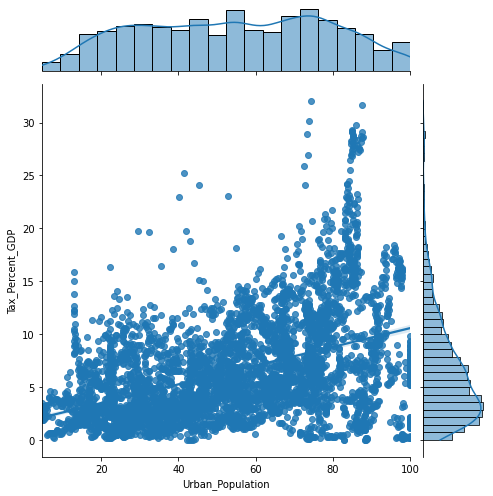

In [23]:
g = sns.jointplot(x='Urban_Population', y='Tax_Percent_GDP', data=df, kind='reg', height=7);

To avoid violating the assumption of independence, reduce noise in the dataset, and ask a more specific question of the data, we can limit the dataset to the single most recent year with available data. Our question becomes:
**How does urban population percentage influence a country's income tax-to-GDP ratio?** By focusing on 2017, our findings will be more relevant to today than they would be if we incorporated data spanning back to 1980. 

However, this does only leave us with 117 observations.

In [24]:
## Create a DataFrame limited to the year 2017
df_2017 = df.loc[df['Year']==2017]
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 13 to 4763
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Entity            117 non-null    object 
 1   Code              117 non-null    object 
 2   Year              117 non-null    int64  
 3   Tax_Percent_GDP   117 non-null    float64
 4   Urban_Population  117 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.5+ KB


With the reduced dataset, the slight positive relationship between the two variables is still apparent. There appears to be more variation in the dependent variable, `Tax_Percent_GDP`, at higher values of the independent variable, `Urban_Population`. There also appears to be a single outlying country with a `Tax_Percent_GDP` just under 30%.

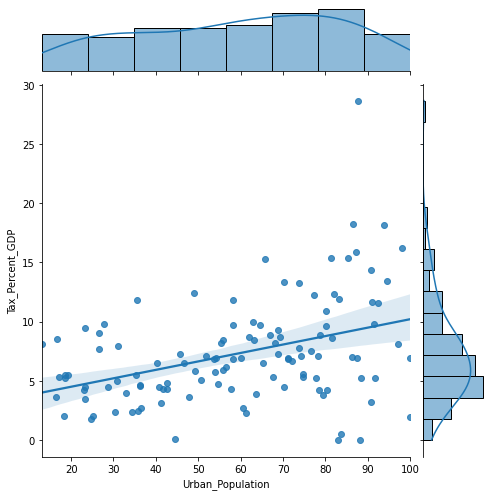

In [25]:
g = sns.jointplot(x='Urban_Population', y='Tax_Percent_GDP', data=df_2017, kind='reg', height=7);

In [26]:
## Check for outliers in the dependent variable
gdp_outliers = z_outliers(df_2017, 'Tax_Percent_GDP')

Z-score method found 1 outliers.


In [27]:
## Identify the outlying country
df_2017.loc[gdp_outliers]

,Entity,Code,Year,Tax_Percent_GDP,Urban_Population
1144,Denmark,DNK,2017,28.674118,87.757


> Denmark is the only outlier (defined as having a z-score more than 3 standard deviations from the mean) in terms of the tax-to-GDP ratio.

> There are no outliers for percent urban population.

In [28]:
## Check for outliers in the independent variable
popn_outliers = z_outliers(df_2017, 'Urban_Population')

Z-score method found 0 outliers.


In [29]:
## Create a new 2017 DataFrame that excludes the identified outlier
df_2017_no_outlier = df_2017[~gdp_outliers]

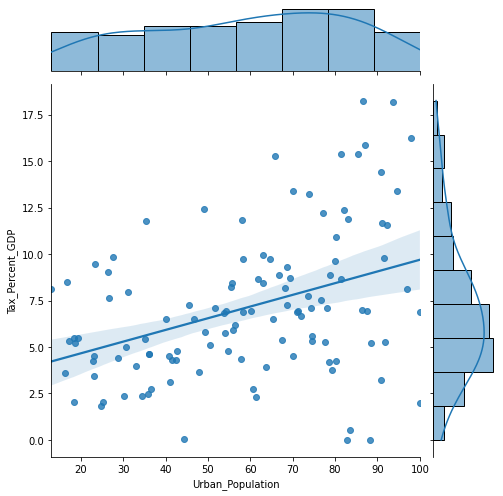

In [30]:
g = sns.jointplot(x='Urban_Population', y='Tax_Percent_GDP', data=df_2017_no_outlier, kind='reg', height=7);

Neither variable is normally distributed. This may be fine since OLS regression only assumes that the residuals are normally distributed. 
> `Urban_Population` is almost somewhat uniformly distributed.<br>
`Tax_Percent_GDP` is right skewed.

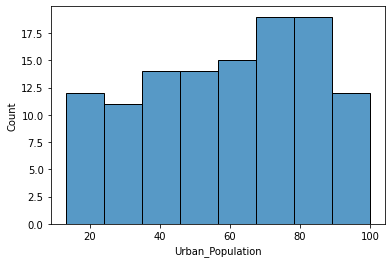

In [31]:
sns.histplot(data=df_2017_no_outlier, x='Urban_Population');

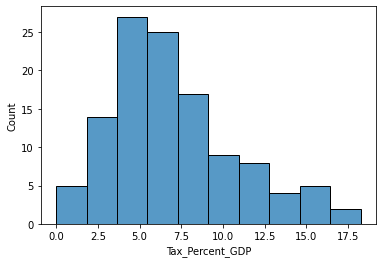

In [32]:
sns.histplot(df_2017_no_outlier['Tax_Percent_GDP']);

# Model

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [34]:
## Define target (dependent) variable for models
target = 'Tax_Percent_GDP'

## Define predictor (independent) variable for models
predictor = 'Urban_Population'

I built three models for comparison:
- One model built with the full dataset
- One model built with all data from 2017
- One model built with 2017 data, excluding Denmark (outlier for `Tax_Percent_GDP`)

The 2017 model with outlier excluded was intended to be the final model and is interpreted at the end of this section. Across all three models, `Urban_Population` had a statistically significant (p-value << 0.01), very slightly positive relationship with `Tax_Percent_GDP`.

## Model with All Years Included

In [35]:
## Build model on full dataset and check results summary
model = build_ols(df, target, predictor)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Tax_Percent_GDP   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     1123.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          1.84e-221
Time:                        20:37:02   Log-Likelihood:                -14014.
No. Observations:                4822   AIC:                         2.803e+04
Df Residuals:                    4820   BIC:                         2.805e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.7040      0.158     10.797      0.000       1.395       2.013
Urban_Population     0.0887      0.003     33.507      0.000       0.083       0.094
==============================================================================
Omnibus:                      888.992   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2177.536
Skew:                           1.022   Prob(JB):                         0.00
Kurtosis:                       5.580   Cond. No.                         148.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

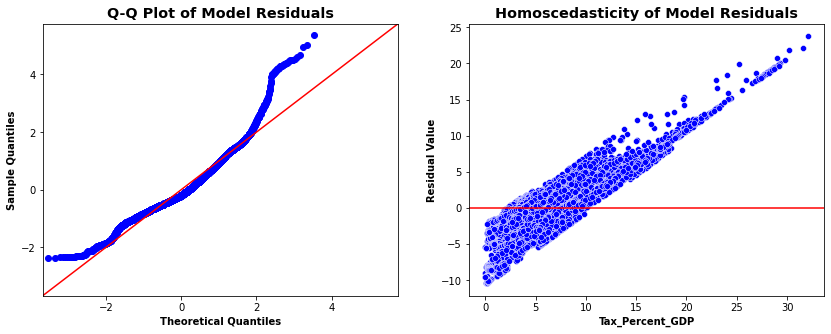

In [36]:
## Visualize normality and spread of model residuals
check_ols_assumptions(model, df, target)

## Models Limited to 2017 Data

### Tax_Percent_GDP Outlier (Denmark) Included

In [37]:
## Build model on all 2017 data and check results summary
model = build_ols(df_2017, target, predictor)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Tax_Percent_GDP   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     20.88
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           1.24e-05
Time:                        20:37:03   Log-Likelihood:                -327.98
No. Observations:                 117   AIC:                             660.0
Df Residuals:                     115   BIC:                             665.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.0666      0.999      3.069      0.003       1.087       5.046
Urban_Population     0.0714      0.016      4.569      0.000       0.040       0.102
==============================================================================
Omnibus:                       31.612   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.492
Skew:                           0.964   Prob(JB):                     1.00e-19
Kurtosis:                       6.772   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

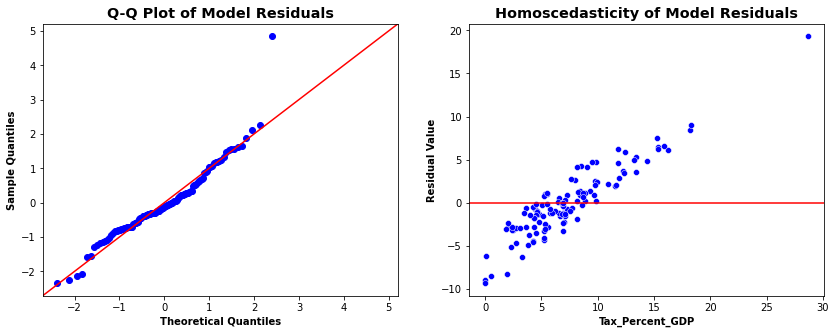

In [38]:
## Visualize normality and spread of model residuals
check_ols_assumptions(model, df_2017, target)

### Tax_Percent_GDP Outlier (Denmark) Excluded

In [39]:
## Build model on 2017 data with single GDP outlier excluded and check results summary
model = build_ols(df_2017_no_outlier, target, predictor)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Tax_Percent_GDP   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     19.99
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           1.85e-05
Time:                        20:37:03   Log-Likelihood:                -312.37
No. Observations:                 116   AIC:                             628.7
Df Residuals:                     114   BIC:                             634.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.3988      0.897      3.789      0.000       1.622       5.176
Urban_Population     0.0629      0.014      4.471      0.000       0.035       0.091
==============================================================================
Omnibus:                        1.625   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.165
Skew:                           0.219   Prob(JB):                        0.558
Kurtosis:                       3.222   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both the intercept and the coefficient of the independent variable are statistically significant. However, the coefficient for `Urban_Population` is very small. Since neither the independent nor dependent variable has been transformed, the coefficient of 0.0629 suggests that for a one unit (percentage point) increase in `Urban_Population`, `Tax_Percent_GDP` tends to increase by about 0.0629 percentage points. Thus, the relationship is statistically significant, but the actual effect size is relatively tiny.

The plots below visualize the distribution of model residuals. The Q-Q plot indicates that the model residuals are relatively normally distributed. However, the assumption of residual homoscedasticity is violated because residual values exhibit a clear pattern of increase with increasing `Tax_Percent_GDP`. Ideally we would see a random scatter of points above and below the red line across all values of the dependent variable.

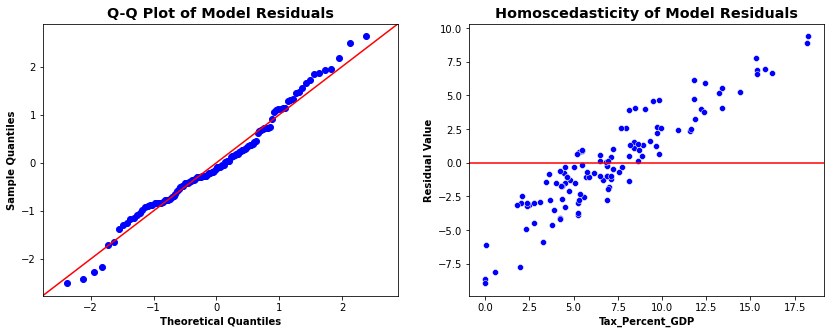

In [40]:
## Visualize normality and spread of model residuals
check_ols_assumptions(model, df_2017_no_outlier, target)